In [57]:
import os
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

In [58]:
import random

def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

# 실행
set_random_seed(42)

In [66]:
def load_distance_matrix_and_tour_from_txt(path, n=20):
    with open(path, "r") as f:
        tokens = f.read().strip().split()
        if "output" in tokens:
            idx = tokens.index("output")
            dist_values = list(map(float, tokens[:idx]))
            tour = [int(x) - 1 for x in tokens[idx + 1:]]
        else:
            raise ValueError("output이 없습니다.")
    dist_matrix = squareform(dist_values)
    return dist_matrix, tour

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from tqdm.notebook import tqdm

# ------------------------
# 1. 환경 클래스
# ------------------------
class TSPEnvironment:
    def __init__(self, distance_matrix, start_city=0):
        self.distance_matrix = distance_matrix
        self.n_stops = distance_matrix.shape[0]
        self.start_city = start_city
        self.total_distance = 0
        self.reset()

    def reset(self):
        self.total_distance = 0
        self.stops = []
        self.current_city = self.start_city
        self.stops.append(self.current_city)
        return self.current_city

    def step(self, next_city):
        prev_city = self.current_city
        reward = -self.distance_matrix[prev_city][next_city]

        self.total_distance += self.distance_matrix[prev_city][next_city]
        self.current_city = next_city
        self.stops.append(next_city)

        done = len(self.stops) == self.n_stops
        if done:
            return_city = self.stops[0]
            self.total_distance += self.distance_matrix[self.current_city][return_city]
            reward += -self.distance_matrix[self.current_city][return_city]
            self.stops.append(return_city)

        return next_city, reward, done

In [61]:
# ------------------------
# 2. Q-learning 에이전트
# ------------------------
class TravelQAgent:
    def __init__(self, states_size, actions_size, distance_matrix=None,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 gamma=0.95, lr=0.8):
        self.states_size = states_size
        self.actions_size = actions_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.lr = lr
        self.reset_memory()
        self.episode_stops = []
        self.dist_matrix = distance_matrix

        if distance_matrix is not None:
            self.Q = -distance_matrix.copy()
            np.fill_diagonal(self.Q, -np.inf)
        else:
            self.Q = np.random.uniform(low=-1, high=1, size=(states_size, actions_size))

    def act(self, s):
        q = np.copy(self.Q[s, :])
        q[self.states_memory] = -np.inf
        valid_actions = [i for i in range(self.actions_size) if i not in self.states_memory]
        if not valid_actions:
            return self.states_memory[0]
        if np.random.rand() > self.epsilon:
            return np.argmax(q)
        else:
            return np.random.choice(valid_actions)

    def train(self, s, a, r, s_next, done):
        self.Q[s, a] += self.lr * (r + self.gamma * np.max(self.Q[s_next, :]) - self.Q[s, a])
        self.remember_state(s)

        if done and self.dist_matrix is not None:
            start_city = self.states_memory[0]
            last_city = self.states_memory[-1]
            return_reward = -self.dist_matrix[last_city][start_city]
            self.Q[last_city, start_city] += self.lr * (return_reward - self.Q[last_city, start_city])

            self.episode_stops.append(self.states_memory.copy())
            self.reset_memory()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def remember_state(self, s):
        self.states_memory.append(s)

    def reset_memory(self):
        self.states_memory = []

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from tqdm.notebook import tqdm

# ------------------------
# 3. 학습 루프
# ------------------------
def run_episode_fixed(env, agent, verbose=1):
    s = env.reset()
    agent.reset_memory()
    i = 0

    while True:
        agent.remember_state(s)
        a = agent.act(s)
        s_next, r, done = env.step(a)

        if verbose:
            print(f"step {i}: from {s} to {a}, reward: {r:.2f}, done: {done}")

        agent.train(s, a, r, s_next, done)
        s = s_next
        i += 1
        if done:
            break

    return env, agent, 0, env.total_distance

# ------------------------
# 4. 여러 에피소드 실행 및 시각화
# ------------------------
def run_n_episodes_with_plot(env, agent, n_episodes=100):
    episode_rewards = []
    total_distances = []

    min_distance = float("inf")
    best_Q = None

    for _ in tqdm(range(n_episodes)):
        env, agent, _, total_distance = run_episode_fixed(env, agent, verbose=0)
        episode_rewards.append(-total_distance)
        total_distances.append(total_distance)

        if total_distance < min_distance:
            min_distance = total_distance
            best_Q = agent.Q.copy()

        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=episode_rewards, color='royalblue')
    
    plt.title("Total Reward per Episode", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Total Reward", fontsize=14)
    formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().set_facecolor('#F2F2F2')
    plt.grid(axis='y', color='white', linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    
    agent.Q = best_Q
    best_path = reconstruct_path(agent, start_city=start_city)
    return env, agent, best_path

In [63]:
# ------------------------
# 5. 경로 복원 및 평가
# ------------------------
def reconstruct_path(agent, start_city=0):
    visited = set()
    path = []
    current = start_city
    path.append(current)
    visited.add(current)

    while len(path) < agent.actions_size:
        q = np.copy(agent.Q[current])
        for v in visited:
            q[v] = -np.inf
        if np.all(q == -np.inf):
            break
        next_city = np.argmax(q)
        path.append(next_city)
        visited.add(next_city)
        current = next_city

    path.append(start_city)
    return path

def compute_path_cost(path, dist_matrix): 
    return sum(dist_matrix[path[i], path[i + 1]] for i in range(len(path) - 1))

def compare_agent_to_optimal(agent_path, optimal_path, dist_matrix):
    agent_cost = compute_path_cost(agent_path, dist_matrix)
    optimal_cost = compute_path_cost(optimal_path, dist_matrix)
    return {
        "agent_cost": agent_cost,
        "optimal_cost": optimal_cost,
        "gap(%)": (agent_cost - optimal_cost) / optimal_cost * 100,
    }

  0%|          | 0/1000 [00:00<?, ?it/s]

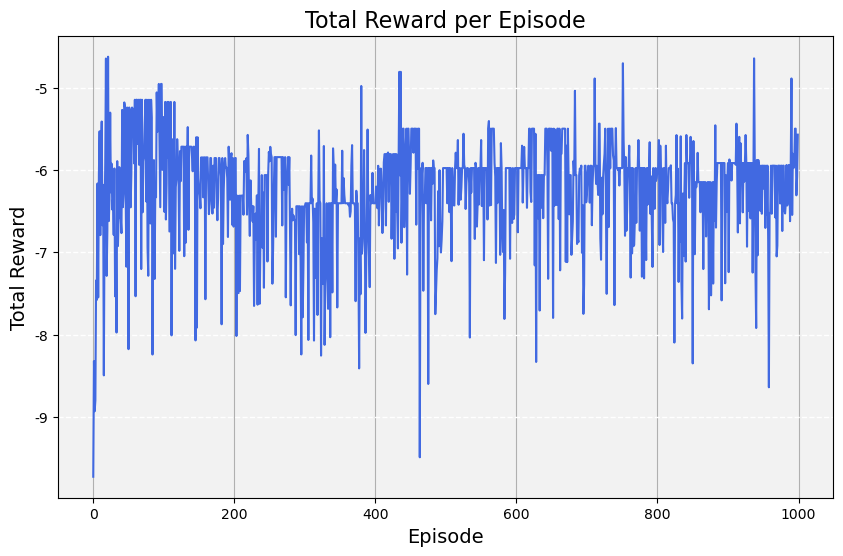

🧾 Result: {'agent_cost': 5.174079444939463, 'optimal_cost': 4.121216380776507, 'gap(%)': 25.547386181275417}


In [115]:
import os

# ------------------------
# 1. 파일 로드
# ------------------------
file_path = os.path.join("dataset", "20-5.txt")

# 거리 행렬 및 최적 경로 로드
dist_matrix, opt_tour = load_distance_matrix_and_tour_from_txt(file_path)

# ------------------------
# 2. 환경 및 에이전트 설정
# ------------------------
start_city = 7 # ✅ 시작점 고정
env = TSPEnvironment(dist_matrix, start_city=start_city)
agent = TravelQAgent(
    states_size=dist_matrix.shape[0],
    actions_size=dist_matrix.shape[1],
    distance_matrix=dist_matrix,
    epsilon=1.0,
    epsilon_decay=0.99,
    epsilon_min=0.05,
    gamma=0.95,
    lr=0.8
)

# ------------------------
# 3. 학습 실행
# ------------------------
env, agent, best_agent_path = run_n_episodes_with_plot(env, agent, n_episodes=1000)

# ------------------------
# 4. 경로 복원 및 평가
# ------------------------
result = compare_agent_to_optimal(best_agent_path, opt_tour, dist_matrix)

# ------------------------
# 5. 결과 출력
# ------------------------
print("🧾 Result:", result)

In [250]:
def run_tsp_experiment(file_path, n_episodes=1000, verbose=True):
    print(f"\n📂 Running on: {file_path}")

    # 거리 행렬 + 최적 경로 불러오기
    dist_matrix, opt_tour = load_distance_matrix_and_tour_from_txt(file_path)

    # 환경 설정
    env = TSPEnvironment(dist_matrix)

    # Q-learning 에이전트 설정
    agent = TravelQAgent(
        states_size=dist_matrix.shape[0],
        actions_size=dist_matrix.shape[1],
        distance_matrix=dist_matrix,
        epsilon=1.0,
        epsilon_decay=0.99,
        epsilon_min=0.05
    )

    # 학습 + 로그 출력
    run_n_episodes_with_plot(env, agent, n_episodes=n_episodes)

    # Q-table 기반 경로 복원
    agent_path = reconstruct_path(agent)
    print(agent_path)
    # 최적 경로와 비교
    print(compare_agent_to_optimal(agent_path, opt_tour, dist_matrix))